In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F # Capas sin parámetros (como ReLU)

# Crear una red neuronal
---

In [0]:
# Una red es una clase que hereda de nn.Module (torch.nn.Module)
class Net (nn.Module):
  def __init__(self, num_channels):
    super(Net, self).__init__()

    self.num_channels = num_channels

    self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels * 2, 3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(self.num_channels * 2, self.num_channels * 4, 3, stride=1, padding=1)

    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)

  def forward(self, x):
    # Empezamos con un x de 3 x 64 x 64
    x = self.conv1(x) # num_channels x 64 x 64

    # max_pool2d divide el tamaño de la matriz por el segundo argumento
    x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32

    x = self.conv2(x) # num_channels*2 x 32 x 32
    x = F.relu(F.max_pool2d(x, 2)) # num_channels*2 x 16 x 16
    x = self.conv3(x) # num_channels*4 x 16 x 16
    x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8

    # view transforma el tamaño del tensor. Con -1 es como decir flatten
    x = x.view(-1, self.num_channels*4*8*8)

    # fc (fully connected || Linear)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    # Log softmax para probabilidades
    x = F.log_softmax(x, dim=1)

    return x

# Traer datos con Pytorch
---

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
!ls '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

test_signs  train_signs  val_signs


In [0]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch/')

In [0]:
from plot_helpers import imshow

In [0]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
class SIGNSDataset(Dataset):
  def __init__(self, base_dir, split='train', transform=None):
    path = os.path.join(base_dir, f'{split}_signs')
    files = os.listdir(path)

    self.filenames = [os.path.join(path, f) for f in files if f.endswith('.jpg')]

    self.targets = [int(f[0]) for f in files]

    self.transform = transform

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self, idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]

In [0]:
signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='train')

In [0]:
len(signs)

864

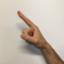

In [0]:
signs[0][0]

# Métodos para entrenar red neuronal
---

## Data loader

In [0]:
import torchvision.transforms as transforms # Coleccion de funciones de preprocesamiento

In [0]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split='train', transform=transforms.ToTensor())

In [0]:
dataloader = DataLoader(trainset, batch_size=32)

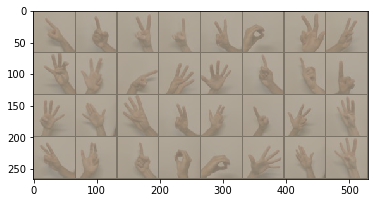

tensor([1, 1, 2, 1, 2, 0, 3, 2, 4, 3, 1, 4, 5, 1, 1, 1, 4, 5, 4, 2, 3, 1, 3, 4,
        2, 3, 1, 0, 0, 5, 5, 4])


In [0]:
from torchvision.utils import make_grid
for inputs, target in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(target)
  break

## Entrenamiento

In [0]:
import torch.optim as optim # Métodos de optimizacion

In [0]:
device = torch.device('cuda')

In [0]:
net = Net(32).to(device)

In [0]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [0]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0

  def update(self, val, size):
    self.S += val
    self.N += size

  def __call__(self):
    return self.S/float(self.N)

# Entrenar red neuronal
---

In [0]:
num_epochs = 100

In [0]:
for epoch in range(num_epochs):
  print(f'Epoch: {epoch + 1}/{num_epochs}')
  print('='*10)

  running_loss = RunningMetric() # Tasa de error (pérdida)
  running_acc = RunningMetric() # Tasa de precisión

  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device) # Convertir a GPU

    optimizer.zero_grad() # Resetear gradientes a cero

    outputs = net(inputs) # Calcular salidas
    _, preds = torch.max(outputs, 1) # Calcular las predicciones segun el porcentaje maximo
    loss = loss_fn(outputs, targets) # Calcular las pérdidad

    loss.backward() # Gradientes calculados
    optimizer.step() # Actualiza los parámetros

  # Estadísticas
  batch_size = inputs.size()[0]
  running_loss.update(loss.item() * batch_size, batch_size)
  running_acc.update(torch.sum(preds == targets).float(), batch_size)
  print('Loss: {:.4f} Accuracy: {:.4f}'.format(running_loss(), running_acc()))

Epoch: 1/100
Loss: 1.7903 Accuracy: 0.1562
Epoch: 2/100
Loss: 1.7904 Accuracy: 0.1562
Epoch: 3/100
Loss: 1.7905 Accuracy: 0.1562
Epoch: 4/100
Loss: 1.7904 Accuracy: 0.1562
Epoch: 5/100
Loss: 1.7904 Accuracy: 0.1562
Epoch: 6/100
Loss: 1.7904 Accuracy: 0.1562
Epoch: 7/100
Loss: 1.7903 Accuracy: 0.1562
Epoch: 8/100
Loss: 1.7902 Accuracy: 0.1562
Epoch: 9/100
Loss: 1.7901 Accuracy: 0.1562
Epoch: 10/100
Loss: 1.7900 Accuracy: 0.1562
Epoch: 11/100
Loss: 1.7898 Accuracy: 0.1562
Epoch: 12/100
Loss: 1.7897 Accuracy: 0.1562
Epoch: 13/100
Loss: 1.7895 Accuracy: 0.1562
Epoch: 14/100
Loss: 1.7894 Accuracy: 0.1562
Epoch: 15/100
Loss: 1.7892 Accuracy: 0.1562
Epoch: 16/100
Loss: 1.7889 Accuracy: 0.1562
Epoch: 17/100
Loss: 1.7887 Accuracy: 0.1562
Epoch: 18/100
Loss: 1.7884 Accuracy: 0.1562
Epoch: 19/100
Loss: 1.7881 Accuracy: 0.1562
Epoch: 20/100
Loss: 1.7878 Accuracy: 0.1562
Epoch: 21/100
Loss: 1.7875 Accuracy: 0.1562
Epoch: 22/100
Loss: 1.7871 Accuracy: 0.1562
Epoch: 23/100
Loss: 1.7868 Accuracy: 0.15